In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [6]:
!pip install albumentations

In [9]:
# Run this before running colab notebook !pip install albumentations==0.4.6

import cv2
import torchvision
import torch
import torchvision.transforms as transforms

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2
device = 'cuda'
torch.manual_seed(2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

class Cifar10SearchDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])

train_transforms = A.Compose(
    [
        A.augmentations.transforms.PadIfNeeded(40,40),
        A.augmentations.transforms.RandomCrop(32,32),
        A.HorizontalFlip(p=0.5),
        A.CoarseDropout(max_holes = 1, max_height=8, max_width=8, min_holes = 1, min_height=8, min_width=8,
                        fill_value=0.4734),
        A.Normalize(
            mean = (0.4914, 0.4822, 0.4465),
            std = (0.2470, 0.2435, 0.2616),
            p =1.0
        ),
        ToTensorV2()
    ],
    p=1.0
)

test_transforms = A.Compose(
    [
        A.Normalize(
            mean = (0.4914, 0.4822, 0.4465),
            std = (0.2470, 0.2435, 0.2616),
            p =1.0
        ),
        ToTensorV2()
    ]
)

class args():
    def __init__(self,device = 'cpu' ,use_cuda = False) -> None:
        self.batch_size = 512
        self.device = device
        self.use_cuda = use_cuda
        self.kwargs = {'num_workers': 2, 'pin_memory': True} if self.use_cuda else {}

trainset = Cifar10SearchDataset(root='./data', train=True,
                                        download=True, transform=train_transforms)
                                        
trainloader = torch.utils.data.DataLoader(trainset, batch_size=args().batch_size,
                                          shuffle=True, **args(use_cuda=True).kwargs)


testset = Cifar10SearchDataset(root='./data', train=False,
                                       download=True, transform=test_transforms)

testloader = torch.utils.data.DataLoader(testset, batch_size=args().batch_size,
                                         shuffle=False, **args(use_cuda=True).kwargs)

Files already downloaded and verified
Files already downloaded and verified


In [30]:
import torch
import torch.nn as nn

class ResBlock(nn.Module):
  def __init__(self,input_channels, *args, **kwargs):
    
    super(ResBlock,self).__init__()

    self.dropout_value = 0.1
    self.input_channels = input_channels

    self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=self.input_channels, out_channels=self.input_channels,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(self.input_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout_value)
    )
    self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=self.input_channels, out_channels=self.input_channels,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(self.input_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout_value) 
    )

  def forward(self,x):
    
    x = self.conv1(x)
    x = self.conv2(x)

    return x

class block(nn.Module):
  def __init__(self,input_channels,output_channels, *args, **kwargs):
    super(block,self).__init__()

    self.input_channels = input_channels
    self.output_channels = output_channels
    self.dropout_value = 0.1

    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels= self.input_channels, out_channels=self.output_channels,
                  kernel_size = (3, 3) ,stride = 1, padding = 1, bias = False),
        nn.MaxPool2d(2,2),
        nn.BatchNorm2d(self.output_channels),
        nn.ReLU(inplace=True),
        nn.Dropout(self.dropout_value)
    )
    self.resblock = ResBlock(self.output_channels)

  def forward(self,x):

    x = self.conv1(x)
    identity = x
    x = self.resblock(x)
    out = x.clone() + identity
    
    return x
class CustomResNet(nn.Module):
  def __init__(self):
    super(CustomResNet,self).__init__()

    self.dropout_value = 0.1

    self.prep_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels = 64,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout_value)
    )
    
    
    self.layer1 = block(64,128)

    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels= 128, out_channels=256,
                  kernel_size = (3, 3) ,stride = 1, padding = 1, bias = False),
        nn.MaxPool2d(2,2),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Dropout(self.dropout_value)
    )

    self.layer3 = block(256,512)

    self.gmp = nn.MaxPool2d(4,4)

    self.fc1 = nn.Linear(in_features=512,out_features=256)
    self.fc2 = nn.Linear(in_features=256,out_features=64)
    self.fc3 = nn.Linear(in_features=64,out_features=10)

    self.intialise_weight()
  
  def forward(self,x):

    x = self.prep_layer(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.gmp(x)
    
    # print(x.shape)

    x = x.view(-1,512)
    
    # print(x.shape)

    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    
    x = x.view(-1,10)

    return F.log_softmax(x)
  
  def intialise_weight(self):
    for m in self.modules():
      if isinstance(m,nn.BatchNorm2d):
        nn.init.constant_(m.weight,0.125)



In [20]:
pip install torch-lr-finder

In [21]:

from torch_lr_finder import LRFinder



  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.86E-03


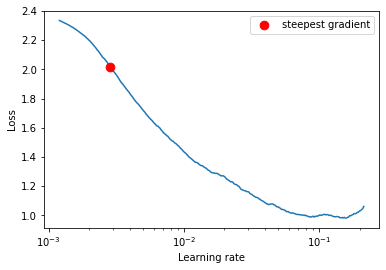

In [22]:

model = CustomResNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=10, num_iter=500)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

  0%|          | 0/400 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.66E-03


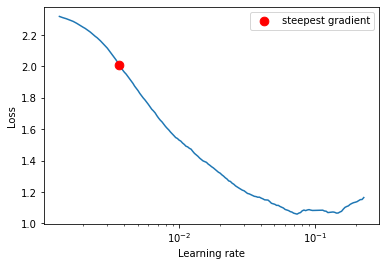

In [15]:
#@title
model = CustomResNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=100, num_iter=400)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state




In [11]:

from tqdm import tqdm


def test(model, device, test_loader):

    model.eval()
    test_loss = 0
    correct = 0
    test_losses = []
    test_acc = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target,reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Test Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100*correct/len(test_loader.dataset))
    
    return test_losses,test_acc


def train(model, device,optimizer, epoch, train_loader):

    model.train() #set  the model  in training mode (which means the model knows to include thing like batchnorm and dropout)
    pbar = tqdm(train_loader)
    correct  = 0
    processed  = 0
    train_acc = []
    train_losses = []
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        # get the inputs
        data = data.to(device)
        target = target.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        #printing training logs
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        train_losses.append(loss.item())

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Train Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

        # if batch_idx % 2000 == 1999:    # print every 2000 mini-batches
        #     print('[%d, %5d] loss: %.3f' %
        #           (epoch + 1, batch_idx + 1, running_loss / 2000))
        #     running_loss = 0.0


    return train_losses,train_acc

In [14]:
import torch.optim as optim

In [18]:
len(trainloader)

98

In [31]:
model = CustomResNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(trainloader), 
                                                epochs=24,pct_start = 5/24, verbose = True, anneal_strategy = 'linear',
                                                div_factor = 10,three_phase = False,base_momentum = 0.8)

train_accuracies = []
train_losses = []
test_accuracies = []
test_losses = []

for epoch in range(1, 25):

    print(f"Epoch {epoch}")
    

    x,y = train(model, device, train_loader = trainloader, optimizer = optimizer,epoch =  epoch)
    
    a,b = test(model, device, test_loader = testloader)
    scheduler.step()
    

    train_losses.append(x)
    test_losses.append(a)
    train_accuracies.append(y)
    test_accuracies.append(b)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


  0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=1.7665544748306274 Batch_id=97 Train Accuracy=20.82: 100%|██████████| 98/98 [00:52<00:00,  1.88it/s]



Test set: Average loss: 2.5500, Test Accuracy: 1353/10000 (13.53%)

Adjusting learning rate of group 0 to 1.0184e-02.
Epoch 2


Loss=1.411885380744934 Batch_id=97 Train Accuracy=39.48: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]



Test set: Average loss: 1.5127, Test Accuracy: 4493/10000 (44.93%)

Adjusting learning rate of group 0 to 1.0368e-02.
Epoch 3


Loss=0.9499127268791199 Batch_id=97 Train Accuracy=57.92: 100%|██████████| 98/98 [00:52<00:00,  1.86it/s]



Test set: Average loss: 0.9838, Test Accuracy: 6378/10000 (63.78%)

Adjusting learning rate of group 0 to 1.0552e-02.
Epoch 4


Loss=0.7566673159599304 Batch_id=97 Train Accuracy=66.87: 100%|██████████| 98/98 [00:52<00:00,  1.86it/s]



Test set: Average loss: 0.8149, Test Accuracy: 7062/10000 (70.62%)

Adjusting learning rate of group 0 to 1.0736e-02.
Epoch 5


Loss=0.6758975386619568 Batch_id=97 Train Accuracy=72.51: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]



Test set: Average loss: 0.6611, Test Accuracy: 7654/10000 (76.54%)

Adjusting learning rate of group 0 to 1.0920e-02.
Epoch 6


Loss=0.6505983471870422 Batch_id=97 Train Accuracy=76.11: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]



Test set: Average loss: 0.6890, Test Accuracy: 7598/10000 (75.98%)

Adjusting learning rate of group 0 to 1.1104e-02.
Epoch 7


Loss=0.6370550394058228 Batch_id=97 Train Accuracy=78.60: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]



Test set: Average loss: 0.5754, Test Accuracy: 8041/10000 (80.41%)

Adjusting learning rate of group 0 to 1.1288e-02.
Epoch 8


Loss=0.6245266795158386 Batch_id=97 Train Accuracy=81.07: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]



Test set: Average loss: 0.5468, Test Accuracy: 8090/10000 (80.90%)

Adjusting learning rate of group 0 to 1.1472e-02.
Epoch 9


Loss=0.5459502935409546 Batch_id=97 Train Accuracy=83.02: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]



Test set: Average loss: 0.4556, Test Accuracy: 8387/10000 (83.87%)

Adjusting learning rate of group 0 to 1.1656e-02.
Epoch 10


Loss=0.436606764793396 Batch_id=97 Train Accuracy=83.98: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]



Test set: Average loss: 0.4751, Test Accuracy: 8343/10000 (83.43%)

Adjusting learning rate of group 0 to 1.1840e-02.
Epoch 11


Loss=0.3821966052055359 Batch_id=97 Train Accuracy=85.02: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]



Test set: Average loss: 0.4677, Test Accuracy: 8344/10000 (83.44%)

Adjusting learning rate of group 0 to 1.2025e-02.
Epoch 12


Loss=0.45533838868141174 Batch_id=97 Train Accuracy=85.99: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]



Test set: Average loss: 0.4379, Test Accuracy: 8494/10000 (84.94%)

Adjusting learning rate of group 0 to 1.2209e-02.
Epoch 13


Loss=0.35071995854377747 Batch_id=97 Train Accuracy=86.81: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]



Test set: Average loss: 0.3973, Test Accuracy: 8625/10000 (86.25%)

Adjusting learning rate of group 0 to 1.2393e-02.
Epoch 14


Loss=0.42306485772132874 Batch_id=97 Train Accuracy=87.36: 100%|██████████| 98/98 [00:52<00:00,  1.86it/s]



Test set: Average loss: 0.4462, Test Accuracy: 8532/10000 (85.32%)

Adjusting learning rate of group 0 to 1.2577e-02.
Epoch 15


Loss=0.293083518743515 Batch_id=97 Train Accuracy=87.93: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]



Test set: Average loss: 0.3790, Test Accuracy: 8733/10000 (87.33%)

Adjusting learning rate of group 0 to 1.2761e-02.
Epoch 16


Loss=0.3075818717479706 Batch_id=97 Train Accuracy=88.68: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]



Test set: Average loss: 0.3551, Test Accuracy: 8741/10000 (87.41%)

Adjusting learning rate of group 0 to 1.2945e-02.
Epoch 17


Loss=0.2551039159297943 Batch_id=97 Train Accuracy=89.44: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]



Test set: Average loss: 0.3516, Test Accuracy: 8808/10000 (88.08%)

Adjusting learning rate of group 0 to 1.3129e-02.
Epoch 18


Loss=0.25764355063438416 Batch_id=97 Train Accuracy=89.70: 100%|██████████| 98/98 [00:52<00:00,  1.86it/s]



Test set: Average loss: 0.3401, Test Accuracy: 8834/10000 (88.34%)

Adjusting learning rate of group 0 to 1.3313e-02.
Epoch 19


Loss=0.3387080430984497 Batch_id=97 Train Accuracy=90.02: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]



Test set: Average loss: 0.3252, Test Accuracy: 8922/10000 (89.22%)

Adjusting learning rate of group 0 to 1.3497e-02.
Epoch 20


Loss=0.20785994827747345 Batch_id=97 Train Accuracy=90.77: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]



Test set: Average loss: 0.3004, Test Accuracy: 9002/10000 (90.02%)

Adjusting learning rate of group 0 to 1.3681e-02.
Epoch 21


Loss=0.3067645728588104 Batch_id=97 Train Accuracy=91.03: 100%|██████████| 98/98 [00:52<00:00,  1.86it/s]



Test set: Average loss: 0.3249, Test Accuracy: 8949/10000 (89.49%)

Adjusting learning rate of group 0 to 1.3865e-02.
Epoch 22


Loss=0.2797403037548065 Batch_id=97 Train Accuracy=91.25: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]



Test set: Average loss: 0.3090, Test Accuracy: 8968/10000 (89.68%)

Adjusting learning rate of group 0 to 1.4049e-02.
Epoch 23


Loss=0.20025832951068878 Batch_id=97 Train Accuracy=91.74: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]



Test set: Average loss: 0.3188, Test Accuracy: 8969/10000 (89.69%)

Adjusting learning rate of group 0 to 1.4233e-02.
Epoch 24


Loss=0.22609268128871918 Batch_id=97 Train Accuracy=91.91: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]



Test set: Average loss: 0.2956, Test Accuracy: 9044/10000 (90.44%)

Adjusting learning rate of group 0 to 1.4417e-02.
